# AIM5004__Assignment #2

* 2022710674, 유주헌(Yoo Joo Hun)

* Training Convolutional Neural Networks (CNN). You are going to write codes in python with whichever deep learning libraries you prefer to use, e.g. pytorch, tensorflow, keras, jax, mxnet, and so on. (10pts)

- - -

## Question - a

(a) Download CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar.html
and report the statistics of the dataset, e.g. how many training (and testing) images,
the size of each image, the number of class and the number of images per each classes.
Also show random 5 images from each classes. Report the mean and standard deviation
of the training datasets for each color channels (R,G,B). (1 pts)

In [1]:
import os
import time
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
from torchvision import models
from efficientnet_pytorch import EfficientNet

### Arguments settings

In [3]:
class Args:
    # arugments
    epochs=5
    bs=4
    lr=0.001
    momentum=0.9
    num_channels=3  # due to RGB channels(image)
    num_classes=10  # total 10 classes in CIFAR-10
    verbose='store_true'
    seed=710674

args = Args()    

np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)

In [4]:
##Setting torch environment

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.7.1  Device:  cuda


### Raw Data Loading

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


### Mean & Standard Deviation

In [6]:
data = train_dataset.data / 255

In [7]:
mean = data.mean(axis = (0,1,2)) 
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}") 

Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


In [8]:
print("The mean value of the Channel 1 is", mean[0])
print("and the standard deviation of channel 1 is", std[0])
print("The mean value of the Channel 2 is", mean[1])
print("and the standard deviation of channel 2 is", std[1])
print("The mean value of the Channel 3 is", mean[2])
print("and the standard deviation of channel 3 is", std[2])

The mean value of the Channel 1 is 0.4913996786152028
and the standard deviation of channel 1 is 0.24703223246328238
The mean value of the Channel 2 is 0.4821584083946074
and the standard deviation of channel 2 is 0.2434851280000556
The mean value of the Channel 3 is 0.4465309144454644
and the standard deviation of channel 3 is 0.26158784172796423


### Prepare Final Dataset

In [9]:
## Data Transforms
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

data_transforms_nor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

In [10]:
## Loading dataset again without normalize.
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
## Loading dataset again with normalize.
train_dataset_nor = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms_nor)
test_dataset_nor = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms_nor)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
## Set trainloader and testloader for torch training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.bs, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.bs, shuffle=False, num_workers=4)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [13]:
## Checking train_dataset
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [14]:
## Checking test_dataset
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### Basic information of CIFAR-10

In [15]:
print("The number of train dataset image is:", train_dataset.data.shape[0])
print("The number of test dataset image is:", test_dataset.data.shape[0])
print("The number of train dataset label is:", len(collections.Counter(train_dataset.targets).keys()))
print("The number of train dataset label is:", len(collections.Counter(test_dataset.targets).keys()))
print("The input image size of CIFAR 10 dataset is", train_dataset.data.shape[1], "x", train_dataset.data.shape[2])
print("The number of dataset in each label for train_dataset is ", collections.Counter(train_dataset.targets))
print("The number of dataset in each label for test_dataset is ", collections.Counter(test_dataset.targets))

The number of train dataset image is: 50000
The number of test dataset image is: 10000
The number of train dataset label is: 10
The number of train dataset label is: 10
The input image size of CIFAR 10 dataset is 32 x 32
The number of dataset in each label for train_dataset is  Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
The number of dataset in each label for test_dataset is  Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


### Sample images

In [16]:
label_list = []
targets = train_dataset.targets
for i in targets:
    label_list.append(i)

In [17]:
train_df = pd.DataFrame(label_list)

In [18]:
class0 = train_df.loc[train_df[0] == 0]
class1 = train_df.loc[train_df[0] == 1]
class2 = train_df.loc[train_df[0] == 2]
class3 = train_df.loc[train_df[0] == 3]
class4 = train_df.loc[train_df[0] == 4]
class5 = train_df.loc[train_df[0] == 5]
class6 = train_df.loc[train_df[0] == 6]
class7 = train_df.loc[train_df[0] == 7]
class8 = train_df.loc[train_df[0] == 8]
class9 = train_df.loc[train_df[0] == 9]

In [19]:
class0_index = class0.index
class1_index = class1.index
class2_index = class2.index
class3_index = class3.index
class4_index = class4.index
class5_index = class5.index
class6_index = class6.index
class7_index = class7.index
class8_index = class8.index
class9_index = class9.index

In [ ]:
print(class0_index)
print(class1_index)
print(class2_index)
print(class3_index)
print(class4_index)
print(class5_index)
print(class6_index)
print(class7_index)
print(class8_index)
print(class9_index)

In [20]:
## Set the train_dataset_data to tensor format. For Sample images
train_dataset_data = train_dataset.data
train_tensor = torch.from_numpy(train_dataset_data)

In [21]:
def SampleImages():
#     ran = random.sample(range(len(train_data)),3)
    plt.figure(figsize=(30,30))
    plt.subplot(10,5,1)
    plt.imshow(train_tensor[29]);plt.axis('off')
    plt.subplot(10,5,2)
    plt.imshow(train_tensor[30]);plt.axis('off')
    plt.subplot(10,5,3)
    plt.imshow(train_tensor[35]);plt.axis('off')
    plt.subplot(10,5,4)
    plt.imshow(train_tensor[49]);plt.axis('off')
    plt.subplot(10,5,5)
    plt.imshow(train_tensor[77]);plt.axis('off')
    plt.subplot(10,5,6)
    plt.imshow(train_tensor[4]);plt.axis('off')
    plt.subplot(10,5,7)
    plt.imshow(train_tensor[5]);plt.axis('off')
    plt.subplot(10,5,8)
    plt.imshow(train_tensor[32]);plt.axis('off')
    plt.subplot(10,5,9)
    plt.imshow(train_tensor[44]);plt.axis('off')
    plt.subplot(10,5,10)
    plt.imshow(train_tensor[45]);plt.axis('off')
    plt.subplot(10,5,11)
    plt.imshow(train_tensor[6]);plt.axis('off')
    plt.subplot(10,5,12)
    plt.imshow(train_tensor[13]);plt.axis('off')
    plt.subplot(10,5,13)
    plt.imshow(train_tensor[18]);plt.axis('off')
    plt.subplot(10,5,14)
    plt.imshow(train_tensor[24]);plt.axis('off')
    plt.subplot(10,5,15)
    plt.imshow(train_tensor[41]);plt.axis('off')
    plt.subplot(10,5,16)
    plt.imshow(train_tensor[9]);plt.axis('off')
    plt.subplot(10,5,17)
    plt.imshow(train_tensor[17]);plt.axis('off')
    plt.subplot(10,5,18)
    plt.imshow(train_tensor[21]);plt.axis('off')
    plt.subplot(10,5,19)
    plt.imshow(train_tensor[26]);plt.axis('off')
    plt.subplot(10,5,20)
    plt.imshow(train_tensor[33]);plt.axis('off')
    plt.subplot(10,5,21)
    plt.imshow(train_tensor[3]);plt.axis('off')
    plt.subplot(10,5,22)
    plt.imshow(train_tensor[10]);plt.axis('off')
    plt.subplot(10,5,23)
    plt.imshow(train_tensor[20]);plt.axis('off')
    plt.subplot(10,5,24)
    plt.imshow(train_tensor[28]);plt.axis('off')
    plt.subplot(10,5,25)
    plt.imshow(train_tensor[34]);plt.axis('off')
    plt.subplot(10,5,26)
    plt.imshow(train_tensor[27]);plt.axis('off')
    plt.subplot(10,5,27)
    plt.imshow(train_tensor[40]);plt.axis('off')
    plt.subplot(10,5,28)
    plt.imshow(train_tensor[51]);plt.axis('off')
    plt.subplot(10,5,29)
    plt.imshow(train_tensor[56]);plt.axis('off')
    plt.subplot(10,5,30)
    plt.imshow(train_tensor[70]);plt.axis('off')
    plt.subplot(10,5,31)
    plt.imshow(train_tensor[0]);plt.axis('off')
    plt.subplot(10,5,32)
    plt.imshow(train_tensor[19]);plt.axis('off')
    plt.subplot(10,5,33)
    plt.imshow(train_tensor[22]);plt.axis('off')
    plt.subplot(10,5,34)
    plt.imshow(train_tensor[23]);plt.axis('off')
    plt.subplot(10,5,35)
    plt.imshow(train_tensor[25]);plt.axis('off')
    plt.subplot(10,5,36)
    plt.imshow(train_tensor[7]);plt.axis('off')
    plt.subplot(10,5,37)
    plt.imshow(train_tensor[11]);plt.axis('off')
    plt.subplot(10,5,38)
    plt.imshow(train_tensor[12]);plt.axis('off')
    plt.subplot(10,5,39)
    plt.imshow(train_tensor[37]);plt.axis('off')
    plt.subplot(10,5,40)
    plt.imshow(train_tensor[43]);plt.axis('off')
    plt.subplot(10,5,41)
    plt.imshow(train_tensor[8]);plt.axis('off')
    plt.subplot(10,5,42)
    plt.imshow(train_tensor[62]);plt.axis('off')
    plt.subplot(10,5,43)
    plt.imshow(train_tensor[69]);plt.axis('off')
    plt.subplot(10,5,44)
    plt.imshow(train_tensor[92]);plt.axis('off')
    plt.subplot(10,5,45)
    plt.imshow(train_tensor[100]);plt.axis('off')
    plt.subplot(10,5,46)
    plt.imshow(train_tensor[1]);plt.axis('off')
    plt.subplot(10,5,47)
    plt.imshow(train_tensor[2]);plt.axis('off')
    plt.subplot(10,5,48)
    plt.imshow(train_tensor[14]);plt.axis('off')
    plt.subplot(10,5,49)
    plt.imshow(train_tensor[15]);plt.axis('off')
    plt.subplot(10,5,50)
    plt.imshow(train_tensor[16]);plt.axis('off')

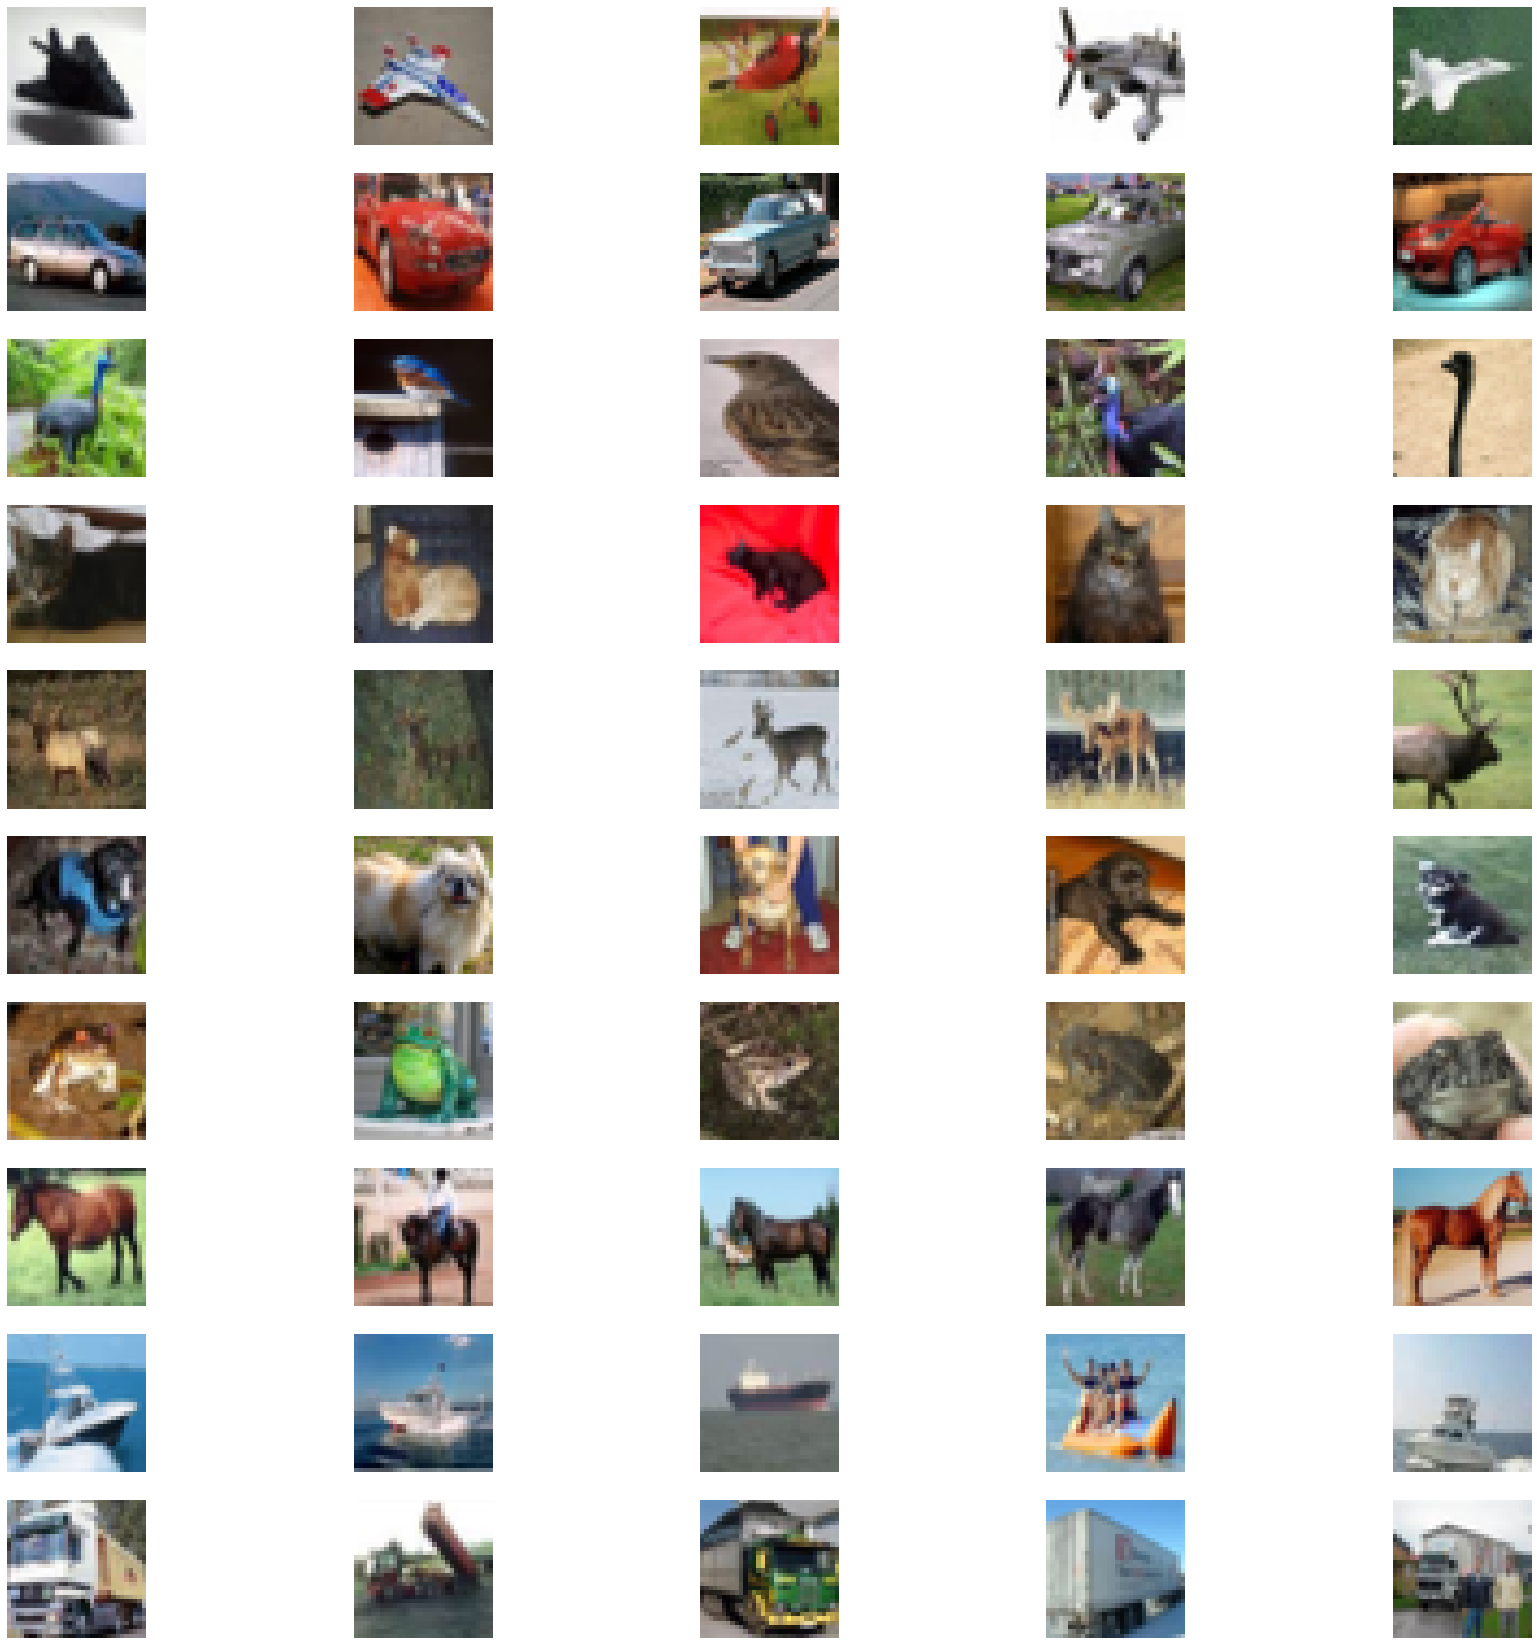

In [22]:
SampleImages()

- - -

## Question - b

(b) Design a CNN architecture and write the training codes with the following hyperparameters. Provide a training loss curve (x-axis: the number of training iteration, y-axis: loss value) and a testing accuracy curve (x-axis: the number of training iteration, y-axis: classification accuracy on testing dataset). (2 pts)

(1) CNN architecture:
>[conv1] → input channels: 3, output channels: 6, kernel size: 5, padding: 0, stride: 1\
[max pooling] → kernel size: 2, stride: 2\
[conv2] → input channels: 6, output channels: 16, kernel size: 5, padding: 0, stride: 1\
[fully connected layer1] → output channels: 120\
[fully connected layer2] → output channels: 84\
[fully connected layer3] → output channels: 10

(2) activation function: ReLU\
(3) loss function: cross entropy loss\
(4) optimization algorithm: SGD\
(5) learning rate: 0.001\
(6) momentum: 0.9\
(7) batch size: 4\
(8) The number of training epoch: 5

In [23]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([9, 7, 3, 3])


In [24]:
print("Batch size is", args.bs)
print("Learning rate is", args.lr)
print("Momentum is ", args.momentum)

Batch size is 4
Learning rate is 0.001
Momentum is  0.9


### CNN model architecture

In [25]:
## CIFAR-10 CNN model architecture design
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        ## convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        ##### 28x28
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        ##### 14x14
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        ##### 10x10
        
        ## fully connected layers
        self.fc1 = nn.Linear(10*10*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, args.num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        x = x.view(-1, 10*10*16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [26]:
model = CIFAR_CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = args.lr, momentum=args.momentum)
print(model)

CIFAR_CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [27]:
## Set trainloader and testloader for torch training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.bs, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.bs, shuffle=False, num_workers=4)

### Training procedures

In [28]:
# Function for checking model performance during CNN model

def train(model, train_loader, optimizer, log_interval):
    model.train()
    print(optimizer.param_groups[0]['lr'])
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [29]:
# Function for checking model performance during the learning process

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader)) 
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [30]:
# Checking train, val loss and accuracy
los_total = []
acc_total = []


for epoch in range(1, args.epochs):
    train(model, train_loader, optimizer, log_interval = 200)
    val_loss, validation_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, val_loss, validation_accuracy))
    
    los_total.append(val_loss)
    acc_total.append(validation_accuracy)

0.001
Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.365622
Train Epoch: 1 [800/50000 (2%)]	Train Loss: 2.304857
Train Epoch: 1 [1600/50000 (3%)]	Train Loss: 2.282699
Train Epoch: 1 [2400/50000 (5%)]	Train Loss: 2.347197
Train Epoch: 1 [3200/50000 (6%)]	Train Loss: 2.353353
Train Epoch: 1 [4000/50000 (8%)]	Train Loss: 2.213706
Train Epoch: 1 [4800/50000 (10%)]	Train Loss: 2.237259
Train Epoch: 1 [5600/50000 (11%)]	Train Loss: 2.192537
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.001328
Train Epoch: 1 [7200/50000 (14%)]	Train Loss: 2.230187
Train Epoch: 1 [8000/50000 (16%)]	Train Loss: 1.759648
Train Epoch: 1 [8800/50000 (18%)]	Train Loss: 2.049746
Train Epoch: 1 [9600/50000 (19%)]	Train Loss: 2.245449
Train Epoch: 1 [10400/50000 (21%)]	Train Loss: 1.889121
Train Epoch: 1 [11200/50000 (22%)]	Train Loss: 1.843772
Train Epoch: 1 [12000/50000 (24%)]	Train Loss: 2.177756
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.534733
Train Epoch: 1 [13600/50000 (27%)]	Train Loss: 1.826151
Train Epo

### Accuracy and Loss plots

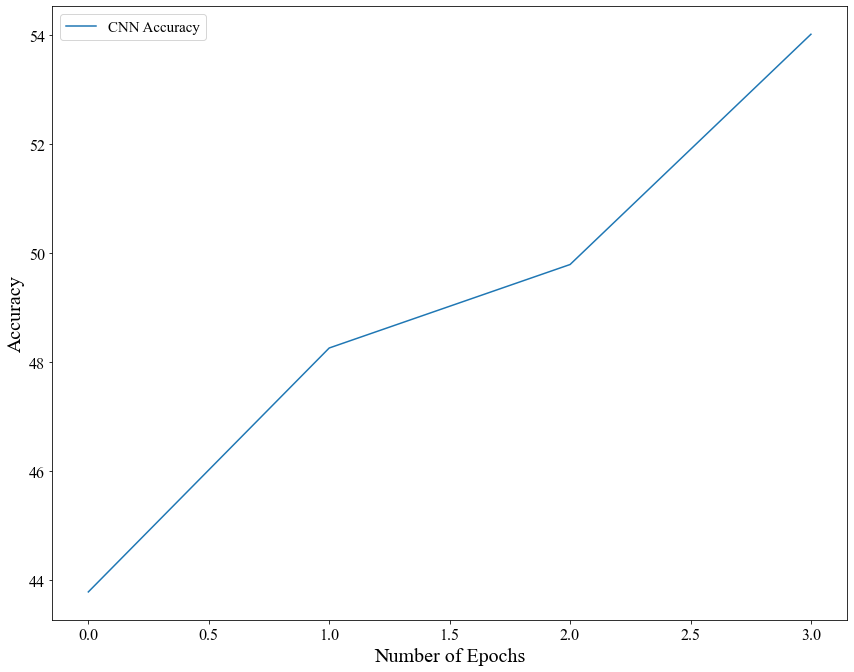

In [31]:
## Accuracy Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs -1), acc_total)


ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Epochs')
ax.legend(['CNN Accuracy'],fontsize=15)
sns.set_style('whitegrid')

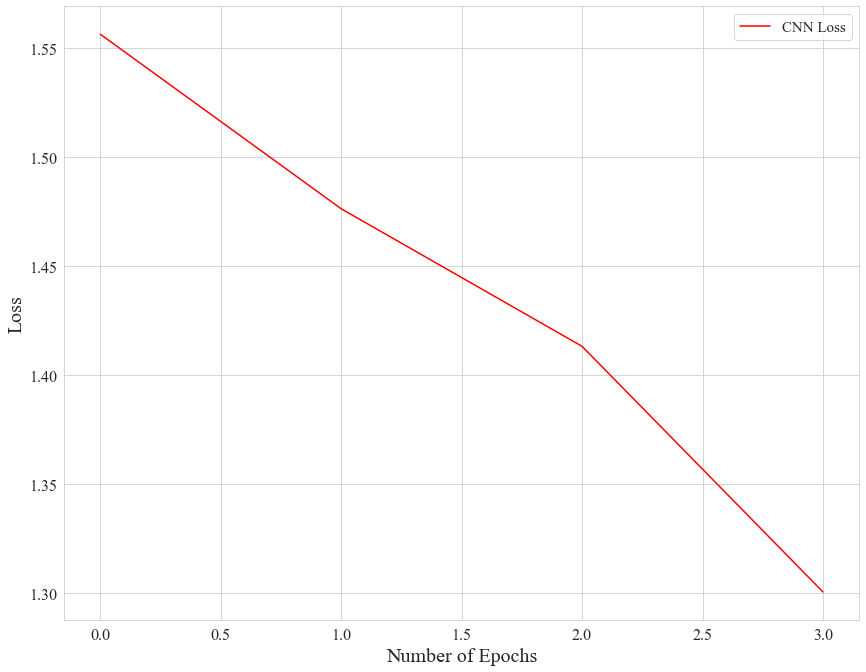

In [32]:
## Loss Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs -1), los_total, '-r')


ax.set_ylabel('Loss')
ax.set_xlabel('Number of Epochs')
ax.legend(['CNN Loss'],fontsize=15)
sns.set_style('whitegrid')

- - - 

## Question - c

(c) Normalize the inputs with mean and standard deviation computed in (1). Compare the training loss and testing accuracy curves by drawing two curves in a same plot. (1pts)

### Normalize

In [33]:
## Loading dataset again with normalize.
train_dataset_nor = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms_nor)
test_dataset_nor = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms_nor)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
## Set trainloader and testloader for torch training
train_loader_nor = torch.utils.data.DataLoader(train_dataset_nor, batch_size=args.bs, shuffle=True, num_workers=4)
test_loader_nor = torch.utils.data.DataLoader(test_dataset_nor, batch_size=args.bs, shuffle=False, num_workers=4)

In [35]:
model = CIFAR_CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = args.lr, momentum=args.momentum)
print(model)

CIFAR_CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Training procedures

In [36]:
# Function for checking model performance during CNN model

def train(model, train_loader_nor, optimizer, log_interval):
    model.train()
    print(optimizer.param_groups[0]['lr'])
    for batch_idx, (image, label) in enumerate(train_loader_nor):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader_nor.dataset), 100. * batch_idx / len(train_loader_nor), 
                loss.item()))

In [37]:
# Function for checking model performance during the learning process

def evaluate(model, test_loader_nor):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader_nor:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader_nor)) 
    test_accuracy = 100. * correct / len(test_loader_nor.dataset)
    
    return test_loss, test_accuracy

In [38]:
## Checking train, val loss and accuracy
los_total_nor = []
acc_total_nor = []


for epoch in range(1, args.epochs):
    train(model, train_loader_nor, optimizer, log_interval = 200)
    val_loss, validation_accuracy = evaluate(model, test_loader_nor)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, val_loss, validation_accuracy))
    
    los_total_nor.append(val_loss)
    acc_total_nor.append(validation_accuracy)

0.001
Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.296609
Train Epoch: 1 [800/50000 (2%)]	Train Loss: 2.296343
Train Epoch: 1 [1600/50000 (3%)]	Train Loss: 2.340268
Train Epoch: 1 [2400/50000 (5%)]	Train Loss: 2.116732
Train Epoch: 1 [3200/50000 (6%)]	Train Loss: 2.270010
Train Epoch: 1 [4000/50000 (8%)]	Train Loss: 1.880295
Train Epoch: 1 [4800/50000 (10%)]	Train Loss: 1.746328
Train Epoch: 1 [5600/50000 (11%)]	Train Loss: 1.717053
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.455881
Train Epoch: 1 [7200/50000 (14%)]	Train Loss: 1.582843
Train Epoch: 1 [8000/50000 (16%)]	Train Loss: 1.351546
Train Epoch: 1 [8800/50000 (18%)]	Train Loss: 1.375669
Train Epoch: 1 [9600/50000 (19%)]	Train Loss: 1.314213
Train Epoch: 1 [10400/50000 (21%)]	Train Loss: 1.599473
Train Epoch: 1 [11200/50000 (22%)]	Train Loss: 0.871180
Train Epoch: 1 [12000/50000 (24%)]	Train Loss: 1.554221
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.008116
Train Epoch: 1 [13600/50000 (27%)]	Train Loss: 1.059045
Train Epo

### Accuracy and Loss plots

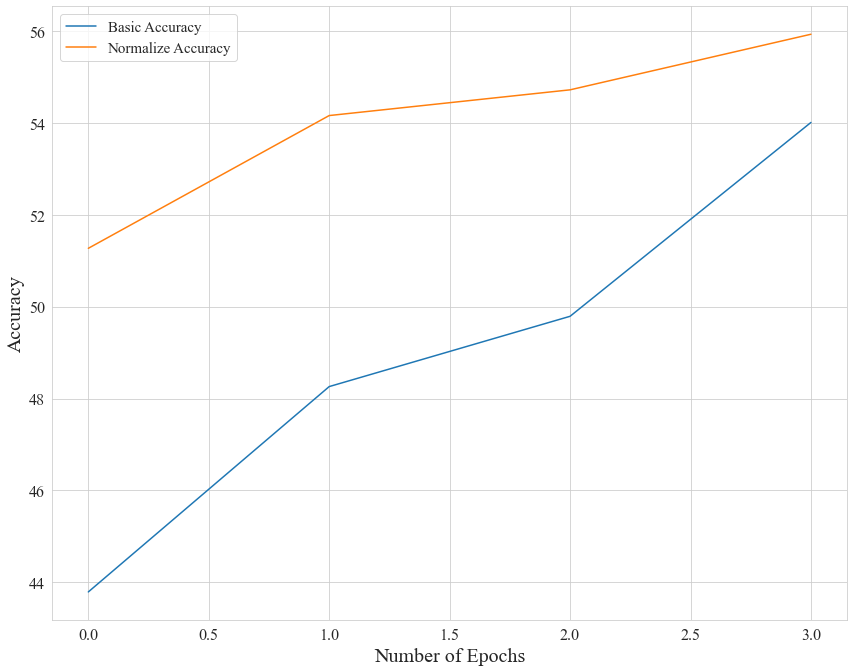

In [39]:
## Accuracy Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs -1), acc_total)
plt.plot(range(args.epochs -1), acc_total_nor)


ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Epochs')
ax.legend(['Basic Accuracy', 'Normalize Accuracy'],fontsize=15)
sns.set_style('whitegrid')

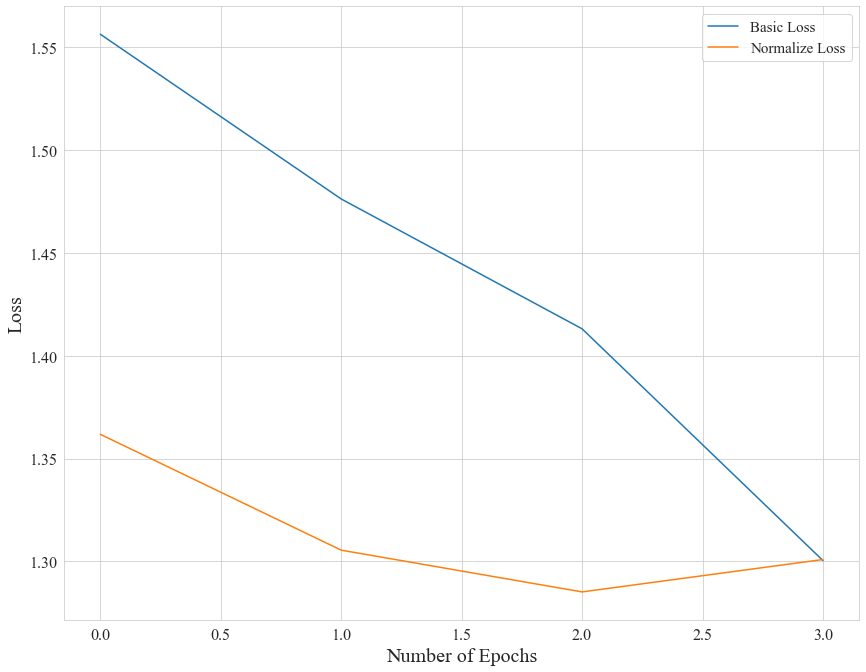

In [40]:
## Loss Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs -1), los_total)
plt.plot(range(args.epochs -1), los_total_nor)


ax.set_ylabel('Loss')
ax.set_xlabel('Number of Epochs')
ax.legend(['Basic Loss', 'Normalize Loss'],fontsize=15)
sns.set_style('whitegrid')

 - - -

## Question - d

(d) Train with a MLP architecture that has the same number of layers (4 layers, each layers have 128 hidden units, ReLU activation function). Compare the training loss and testing accuracy by drawing two curves in a same plot. (2 pts)

In [41]:
## Set trainloader and testloader for torch training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.bs, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.bs, shuffle=False, num_workers=4)

### MLP model architecture

In [42]:
class CIFAR_MLP(nn.Module):
    def __init__(self):
        super(CIFAR_MLP, self).__init__()
        self.layer1 = nn.Linear(32 * 32 * 3, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.relu(x)
        x = self.layer4(x)
        x = F.log_softmax(x, dim=1)
        return x

In [43]:
model_MNIST = CIFAR_MLP()
model_MLP = model_MNIST.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_MLP.parameters(), lr = args.lr, momentum=args.momentum)
print(model_MLP)

CIFAR_MLP(
  (layer1): Linear(in_features=3072, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=10, bias=True)
)


### Training procedure

In [44]:
# Checking train, val loss and accuracy
los_total_mlp = []
acc_total_mlp = []

for epoch in range(1, args.epochs):
    train(model_MLP, train_loader, optimizer, log_interval = 200)
    val_loss, validation_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, val_loss, validation_accuracy))
    
    los_total_mlp.append(val_loss)
    acc_total_mlp.append(validation_accuracy)

0.001
Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.289319
Train Epoch: 1 [800/50000 (2%)]	Train Loss: 2.355545
Train Epoch: 1 [1600/50000 (3%)]	Train Loss: 2.295912
Train Epoch: 1 [2400/50000 (5%)]	Train Loss: 2.125844
Train Epoch: 1 [3200/50000 (6%)]	Train Loss: 2.144767
Train Epoch: 1 [4000/50000 (8%)]	Train Loss: 2.331561
Train Epoch: 1 [4800/50000 (10%)]	Train Loss: 2.421021
Train Epoch: 1 [5600/50000 (11%)]	Train Loss: 2.022875
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.062941
Train Epoch: 1 [7200/50000 (14%)]	Train Loss: 1.922015
Train Epoch: 1 [8000/50000 (16%)]	Train Loss: 1.635866
Train Epoch: 1 [8800/50000 (18%)]	Train Loss: 1.934392
Train Epoch: 1 [9600/50000 (19%)]	Train Loss: 2.140893
Train Epoch: 1 [10400/50000 (21%)]	Train Loss: 2.578058
Train Epoch: 1 [11200/50000 (22%)]	Train Loss: 1.975301
Train Epoch: 1 [12000/50000 (24%)]	Train Loss: 2.222271
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.719175
Train Epoch: 1 [13600/50000 (27%)]	Train Loss: 1.902280
Train Epo

### Accuracy and Loss plots

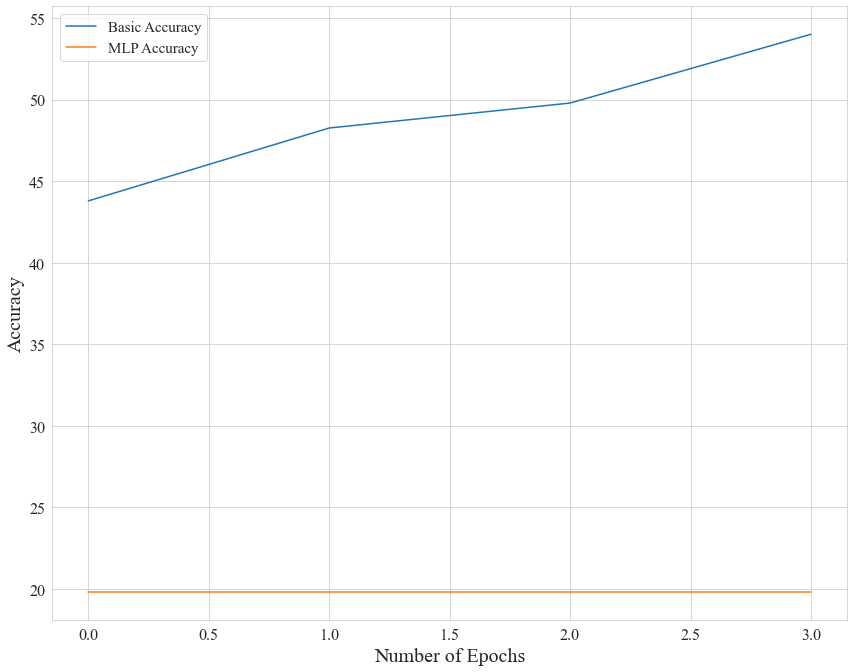

In [45]:
## Accuracy Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs -1), acc_total)
plt.plot(range(args.epochs -1), acc_total_mlp)


ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Epochs')
ax.legend(['Basic Accuracy', 'MLP Accuracy'],fontsize=15)
sns.set_style('whitegrid')

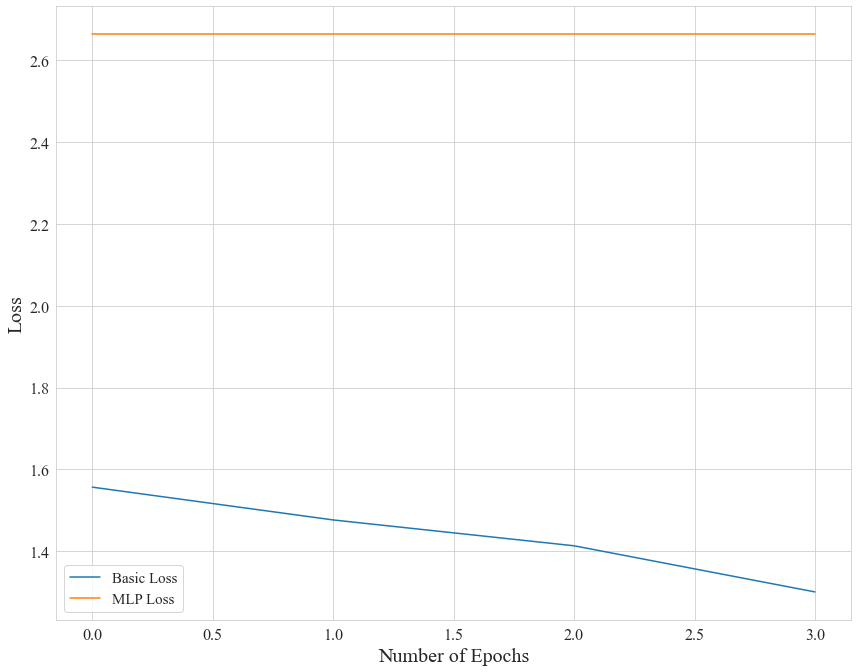

In [46]:
## Loss Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs -1), los_total)
plt.plot(range(args.epochs -1), los_total_mlp)


ax.set_ylabel('Loss')
ax.set_xlabel('Number of Epochs')
ax.legend(['Basic Loss', 'MLP Loss'],fontsize=15)
sns.set_style('whitegrid')

 - - -

## Question - e

(e) Train with Adam optimizer and compare the training loss and testing accuracy by drawing two curves in a same plot. (2 pts)

### Adam Optimizer 

In [47]:
model = CIFAR_CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = args.lr)
print(model)

CIFAR_CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Training procedures

In [48]:
# Checking train, val loss and accuracy
los_total_adam = []
acc_total_adam = []


for epoch in range(1, args.epochs):
    train(model, train_loader, optimizer, log_interval = 200)
    val_loss, validation_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, val_loss, validation_accuracy))
    
    los_total_adam.append(val_loss)
    acc_total_adam.append(validation_accuracy)

0.001
Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.272257
Train Epoch: 1 [800/50000 (2%)]	Train Loss: 2.182492
Train Epoch: 1 [1600/50000 (3%)]	Train Loss: 2.440228
Train Epoch: 1 [2400/50000 (5%)]	Train Loss: 1.942475
Train Epoch: 1 [3200/50000 (6%)]	Train Loss: 1.384074
Train Epoch: 1 [4000/50000 (8%)]	Train Loss: 1.701860
Train Epoch: 1 [4800/50000 (10%)]	Train Loss: 1.937853
Train Epoch: 1 [5600/50000 (11%)]	Train Loss: 1.541574
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.783015
Train Epoch: 1 [7200/50000 (14%)]	Train Loss: 2.015481
Train Epoch: 1 [8000/50000 (16%)]	Train Loss: 1.969615
Train Epoch: 1 [8800/50000 (18%)]	Train Loss: 1.743667
Train Epoch: 1 [9600/50000 (19%)]	Train Loss: 1.462686
Train Epoch: 1 [10400/50000 (21%)]	Train Loss: 1.398458
Train Epoch: 1 [11200/50000 (22%)]	Train Loss: 1.723274
Train Epoch: 1 [12000/50000 (24%)]	Train Loss: 2.646850
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.612701
Train Epoch: 1 [13600/50000 (27%)]	Train Loss: 0.972506
Train Epo

### Accuracy and Loss plots

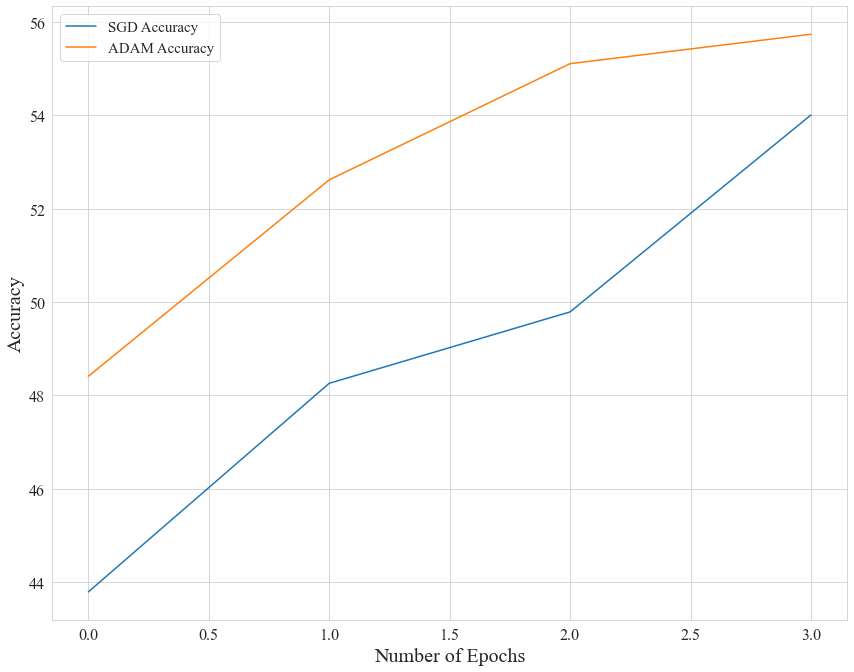

In [49]:
## Accuracy Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs -1), acc_total)
plt.plot(range(args.epochs -1), acc_total_adam)


ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Epochs')
ax.legend(['SGD Accuracy', 'ADAM Accuracy'],fontsize=15)
sns.set_style('whitegrid')

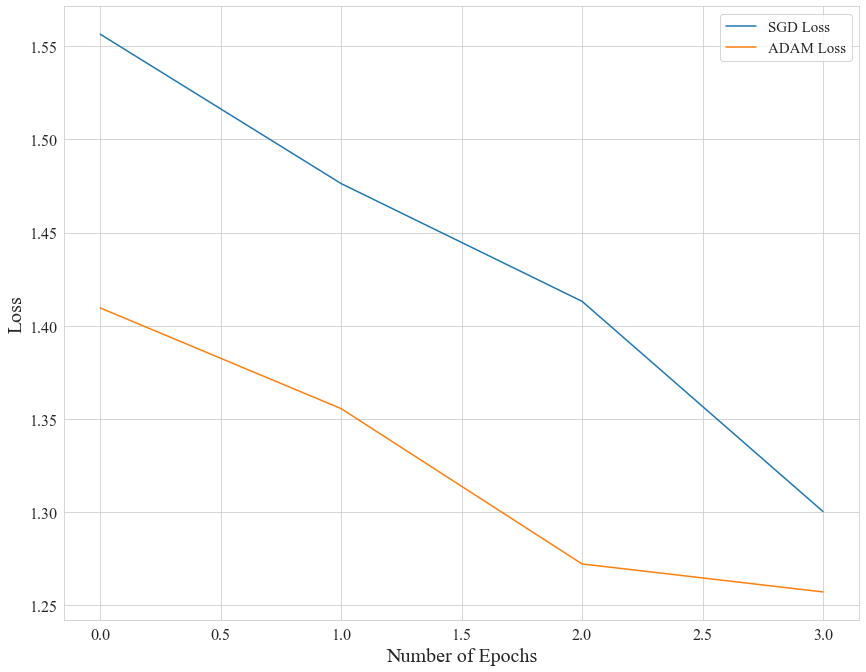

In [50]:
## Loss Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

## edit the plot list here
plt.plot(range(args.epochs -1), los_total)
plt.plot(range(args.epochs -1), los_total_adam)


ax.set_ylabel('Loss')
ax.set_xlabel('Number of Epochs')
ax.legend(['SGD Loss', 'ADAM Loss'],fontsize=15)
sns.set_style('whitegrid')

- - -

## Question - f

(f) Change the hyperparameters and network architectures to achieve better training loss and testing accuracy curves. Provide the final architecture and hyperparameters that you used. (2 pts)

### Arguments/Hyperparameters settings

In [66]:
class Args:
    # arugments
    epochs=50
    bs=16
    lr=0.001
    momentum=0.9
    num_channels=3  # due to RGB channels(image)
    num_classes=10  # total 10 classes in CIFAR-10
    verbose='store_true'
    seed=710674

args = Args()    

np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)

### Data Transforms

In [67]:
data_transforms_my = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.ColorJitter(contrast=(0.3,1), saturation=(0.3,1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

In [68]:
## Loading dataset again with normalize.
train_dataset_my = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms_my)
test_dataset_my = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms_my)

Files already downloaded and verified
Files already downloaded and verified


In [69]:
## Set trainloader and testloader for torch training
train_loader_my = torch.utils.data.DataLoader(train_dataset_my, batch_size=args.bs, shuffle=True, num_workers=4)
test_loader_my = torch.utils.data.DataLoader(test_dataset_my, batch_size=args.bs, shuffle=False, num_workers=4)

In [70]:
dataiter = iter(train_loader_my)
images, labels = dataiter.next()
print(labels)

tensor([9, 7, 3, 3, 8, 3, 2, 7, 6, 0, 4, 9, 9, 0, 6, 7])


### Pre-trained models

In [71]:
# model_res = models.resnet18(num_classes=2, pretrained=True)
model_eff3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=args.num_classes)
model_resnet18 = models.resnet18(pretrained=True)
model_resnet152 = models.resnet152(pretrained=True)

Loaded pretrained weights for efficientnet-b3


In [72]:
# model_resnet18.fc = nn.Linear(in_features = 512, out_features = 256)
# additional_layer = nn.Linear(in_features = 256, out_features = args.num_classes)
# model_resnet = nn.Sequential(model_resnet18, additional_layer)

model_resnet152.fc = nn.Linear(in_features = 2048, out_features = 512)
additional_layer = nn.Linear(in_features = 512, out_features = args.num_classes)
model_resnet = nn.Sequential(model_resnet152, additional_layer)


### Final selected Model Architecture

In [73]:
# model_resnet18
# model_resnet152
model_eff3

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

### Finalize the training model

In [74]:
# model_my = CNN_my(args.num_channels, num_classes = args.num_classes).to(DEVICE)
# model_my = CIFAR_LeNet().to(DEVICE)
model_my = model_eff3.to(DEVICE)
# model_my = model_resnet.to(DEVICE)

### Optimizer and Scheduler

In [75]:
# Setting Optimizer and Objective Function

optimizer = torch.optim.Adam(model_my.parameters(), lr = args.lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, total_steps=args.epochs, anneal_strategy='cos')
criterion = nn.CrossEntropyLoss() ## setup the loss function

### Training procedures

In [76]:
# Function for checking model performance during CNN model

def train(model_my, train_loader_my, optimizer, log_interval):
    model_my.train()
    print(optimizer.param_groups[0]['lr'])
    for batch_idx, (image, label) in enumerate(train_loader_my):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model_my(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader_my.dataset), 100. * batch_idx / len(train_loader_my), 
                loss.item()))

In [77]:
# Function for checking model performance during the learning process

def evaluate(model_my, test_loader_my):
    model_my.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader_my:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model_my(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader_my)) 
    test_accuracy = 100. * correct / len(test_loader_my.dataset)
    
    return test_loss, test_accuracy

In [78]:
# Checking train, val loss and accuracy
los_total_my = []
acc_total_my = []


for epoch in range(1, args.epochs):
    train(model_my, train_loader_my, optimizer, log_interval = 200)
    val_loss, validation_accuracy = evaluate(model_my, test_loader_my)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, val_loss, validation_accuracy))
    
    los_total_my.append(val_loss)
    acc_total_my.append(validation_accuracy)

0.00019999999999999966
Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.341875
Train Epoch: 1 [3200/50000 (6%)]	Train Loss: 1.871906
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.298271
Train Epoch: 1 [9600/50000 (19%)]	Train Loss: 1.111460
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.390077
Train Epoch: 1 [16000/50000 (32%)]	Train Loss: 0.944591
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.282498
Train Epoch: 1 [22400/50000 (45%)]	Train Loss: 1.182409
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.177376
Train Epoch: 1 [28800/50000 (58%)]	Train Loss: 1.422016
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.053221
Train Epoch: 1 [35200/50000 (70%)]	Train Loss: 0.667453
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 0.915346
Train Epoch: 1 [41600/50000 (83%)]	Train Loss: 0.829232
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.220545
Train Epoch: 1 [48000/50000 (96%)]	Train Loss: 0.957061

[EPOCH: 1], 	Test Loss: 0.7791, 	Test Accuracy: 74.59 % 

0.00019999999999999966
Train Ep

### Accuracy and Loss plots

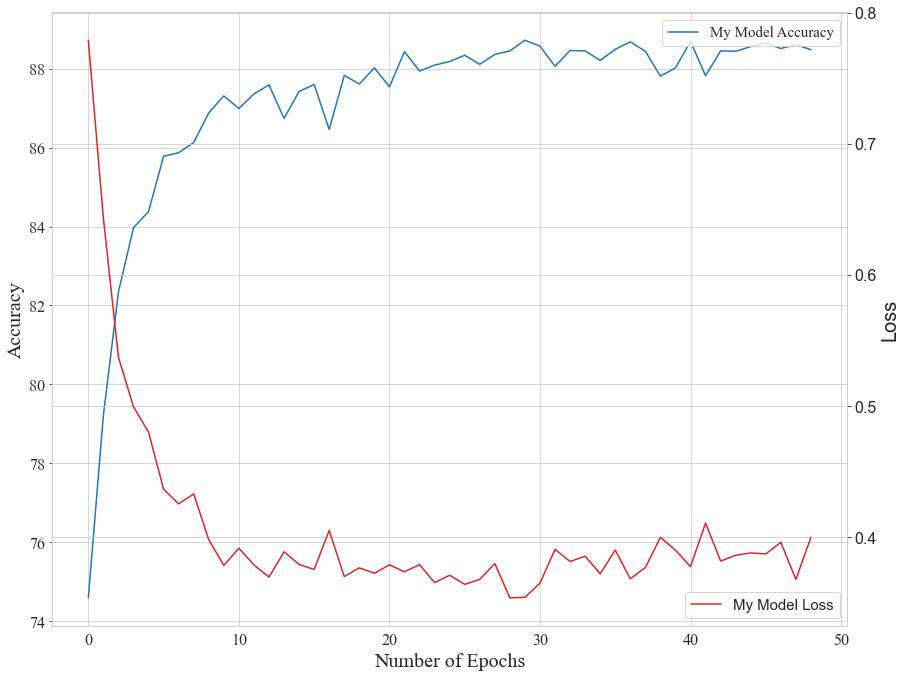

In [79]:
## Accuracy Graphs
plt.rc('font', family='Times New Roman', serif='Times')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20)

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=-1.16, right=1.99, top=.97)

color ='tab:blue'
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of Epochs')
plt.plot(range(args.epochs -1), acc_total_my)
ax.legend(['My Model Accuracy'],fontsize=15, loc='upper right')
sns.set_style('whitegrid')

ax1 = ax.twinx()
color = 'tab:red'
ax1.set_ylabel('Loss')
ax1.plot(range(args.epochs -1), los_total_my, color = color)
ax1.legend(['My Model Loss'], fontsize=15, loc='lower right')
sns.set_style('whitegrid')